In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn

data = pd.read_csv('AMD.csv')

In [2]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1980-03-17,3.145833
1,1980-03-18,3.031250
2,1980-03-19,3.041667
3,1980-03-20,3.010417
4,1980-03-21,2.916667
...,...,...
10907,2023-06-21,112.110001
10908,2023-06-22,110.699997
10909,2023-06-23,110.010002
10910,2023-06-26,107.510002


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

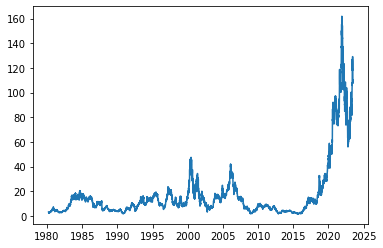

In [4]:
data["Date"] = pd.to_datetime(data["Date"])
plt.plot(data["Date"], data["Close"])

In [5]:
from copy import deepcopy as dc
def preparedf(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = preparedf(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1980-03-26,2.447917,2.604167,2.666667,2.916667,3.010417,3.041667,3.031250,3.145833
1980-03-27,2.375000,2.447917,2.604167,2.666667,2.916667,3.010417,3.041667,3.031250
1980-03-28,2.541667,2.375000,2.447917,2.604167,2.666667,2.916667,3.010417,3.041667
1980-03-31,2.541667,2.541667,2.375000,2.447917,2.604167,2.666667,2.916667,3.010417
1980-04-01,2.739583,2.541667,2.541667,2.375000,2.447917,2.604167,2.666667,2.916667
...,...,...,...,...,...,...,...,...
2023-06-21,112.110001,118.930000,120.080002,124.239998,127.330002,124.529999,129.190002,124.919998
2023-06-22,110.699997,112.110001,118.930000,120.080002,124.239998,127.330002,124.529999,129.190002
2023-06-23,110.010002,110.699997,112.110001,118.930000,120.080002,124.239998,127.330002,124.529999


In [6]:
np_df = shifted_df.to_numpy()
np_df

array([[  2.447917,   2.604167,   2.666667, ...,   3.041667,   3.03125 ,
          3.145833],
       [  2.375   ,   2.447917,   2.604167, ...,   3.010417,   3.041667,
          3.03125 ],
       [  2.541667,   2.375   ,   2.447917, ...,   2.916667,   3.010417,
          3.041667],
       ...,
       [110.010002, 110.699997, 112.110001, ..., 124.239998, 127.330002,
        124.529999],
       [107.510002, 110.010002, 110.699997, ..., 120.080002, 124.239998,
        127.330002],
       [110.389999, 107.510002, 110.010002, ..., 118.93    , 120.080002,
        124.239998]])

In [7]:
np_df.shape

(10905, 8)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
np_df = scaler.fit_transform(np_df)
np_df

array([[-0.98966976, -0.98772017, -0.98694033, ..., -0.98226131,
        -0.98239129, -0.9809616 ],
       [-0.99057957, -0.98966976, -0.98772017, ..., -0.98265123,
        -0.98226131, -0.98239129],
       [-0.98850001, -0.99057957, -0.98966976, ..., -0.98382099,
        -0.98265123, -0.98226131],
       ...,
       [ 0.35242372,  0.36103306,  0.37862622, ...,  0.52997685,
         0.56853202,  0.53359531],
       [ 0.32123026,  0.35242372,  0.36103306, ...,  0.47807098,
         0.52997685,  0.56853202],
       [ 0.35716509,  0.32123026,  0.35242372, ...,  0.46372197,
         0.47807098,  0.52997685]])

In [9]:
X = np_df[:, 1:]
y = np_df[:, 0]
X.shape, y.shape

((10905, 7), (10905,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.9809616 , -0.98239129, -0.98226131, ..., -0.98382099,
        -0.98694033, -0.98772017],
       [-0.98239129, -0.98226131, -0.98265123, ..., -0.98694033,
        -0.98772017, -0.98966976],
       [-0.98226131, -0.98265123, -0.98382099, ..., -0.98772017,
        -0.98966976, -0.99057957],
       ...,
       [ 0.53359531,  0.56853202,  0.52997685, ...,  0.46372197,
         0.37862622,  0.36103306],
       [ 0.56853202,  0.52997685,  0.47807098, ...,  0.37862622,
         0.36103306,  0.35242372],
       [ 0.52997685,  0.47807098,  0.46372197, ...,  0.36103306,
         0.35242372,  0.32123026]])

In [11]:
split_index = int(len(X) * 0.95)
split_index

10359

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10359, 7), (546, 7), (10359,), (546,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10359, 7, 1), (546, 7, 1), (10359, 1), (546, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([10359, 7, 1]),
 torch.Size([546, 7, 1]),
 torch.Size([10359, 1]),
 torch.Size([546, 1]))

In [15]:
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_index % 100 == 99:  
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('|--------------------------------------------------------|')
    print()

In [22]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.603
Batch 200, Loss: 0.075
Batch 300, Loss: 0.023
Batch 400, Loss: 0.023
Batch 500, Loss: 0.018
Batch 600, Loss: 0.015

Val Loss: 0.563
|--------------------------------------------------------|

Epoch: 2
Batch 100, Loss: 0.015
Batch 200, Loss: 0.009
Batch 300, Loss: 0.010
Batch 400, Loss: 0.006
Batch 500, Loss: 0.005
Batch 600, Loss: 0.004

Val Loss: 0.173
|--------------------------------------------------------|

Epoch: 3
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.096
|--------------------------------------------------------|

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.077
|--------------------------------------------------------|

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Bat

Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.006
|--------------------------------------------------------|

Epoch: 38
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.006
|--------------------------------------------------------|

Epoch: 39
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.007
|--------------------------------------------------------|

Epoch: 40
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.006
|--------------------------------------------------------|

Epoch: 41
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.006
|------------------------------------

Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.006
|--------------------------------------------------------|

Epoch: 75
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.005
|--------------------------------------------------------|

Epoch: 76
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.005
|--------------------------------------------------------|

Epoch: 77
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.005
|--------------------------------------------------------|

Epoch: 78
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 50

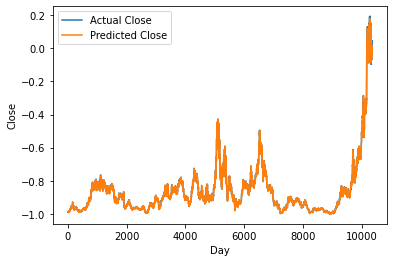

In [23]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [24]:
train_predictions = predicted.flatten()
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)
train_predictions = dc(dummies[:, 0])
train_predictions

array([ 2.59546634,  2.45259539,  2.37584788, ..., 81.43961686,
       79.38610139, 82.38954408])

In [25]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_train = dc(dummies[:, 0])
new_y_train

array([ 2.44791869,  2.37500234,  2.5416676 , ..., 79.05999791,
       82.76000199, 85.41000399])

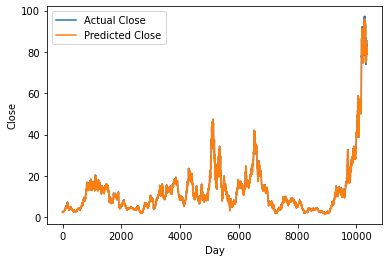

In [26]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)
test_predictions = dc(dummies[:, 0])
test_predictions

array([ 84.95881887,  84.95405977,  83.9346873 ,  83.8151855 ,
        81.87739082,  79.00895491,  78.84213082,  78.13938543,
        78.06317652,  78.83915593,  76.34441511,  76.8779479 ,
        74.99891169,  73.40690955,  74.68930025,  74.82129274,
        74.56020024,  76.15319481,  77.91039805,  77.21804505,
        77.40491947,  77.85502171,  78.33088519,  78.44083295,
        79.91911707,  80.68824027,  81.75064707,  80.38239312,
        81.41749451,  81.36331839,  80.93554153,  80.09240327,
        81.43579525,  81.33784735,  81.49999116,  80.58102735,
        80.19087425,  84.04486316,  84.45685318,  82.64664658,
        83.38470963,  83.73183257,  85.69281787,  85.47337437,
        86.65917982,  88.85128006,  92.66740277,  92.61015622,
        93.71353548,  93.75413413,  90.63056983,  89.64169441,
        90.53676777,  90.52445502,  90.01419823,  88.94693141,
        87.06474356,  85.99900479,  86.47975934,  86.9417438 ,
        88.85319086,  90.51003441,  91.43654112,  91.29

In [28]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_test = dc(dummies[:, 0])
new_y_test

array([ 85.20999906,  84.01999701,  83.91000401,  81.620003  ,
        78.55000295,  78.61000106,  77.83000209,  77.889999  ,
        78.80999793,  75.98999826,  76.83000191,  74.63999907,
        73.08999585,  74.58999627,  74.65000214,  74.4400022 ,
        76.23000323,  78.05999802,  77.16999814,  77.44000186,
        77.86000115,  78.33999615,  78.419998  ,  80.08000199,
        80.80999801,  81.970001  ,  80.27999901,  81.580002  ,
        81.34999802,  80.88999896,  79.95999906,  81.559998  ,
        81.30999799,  81.55000301,  80.47000102,  80.11000104,
        84.55999788,  84.65000191,  82.58999597,  83.58000204,
        83.81999999,  86.09999804,  85.62000304,  87.08000194,
        89.51999698,  93.92999991,  93.30999838,  94.69999731,
        94.47000078,  90.54000122,  89.7399982 ,  90.9000018 ,
        90.80999807,  90.26000189,  89.05000326,  86.93000011,
        85.889999  ,  86.580002  ,  87.110001  ,  89.41000384,
        91.20999898,  92.15000195,  91.81999983,  91.02

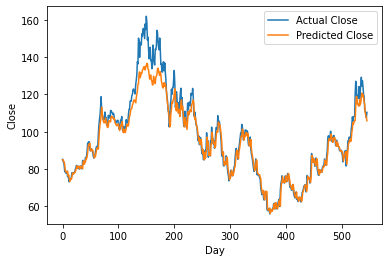

In [29]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
